In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hist
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from utils import data_prep
from lifelines import KaplanMeierFitter

In [276]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load data, converting columns types for convenience, labeling NAs
df = data_prep.load_and_prep_data("data/ncdatachallenge-2021-v1.csv")

In [95]:
df

,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency,pregnant
0,22.942130,31,SE,"No, never",University,Wake same every workday,1,pregnant,0.640000,25.588235,2.526332,True,0.200000,True
1,19.886054,34,Unreported,Unreported,University,Unreported,7,pregnant,0.009569,30.875000,3.522884,True,0.052632,True
2,29.323049,41,SE,"No, never",University,Several times during the night,4,not_pregnant,0.298246,27.666667,2.503331,True,0.149123,False
3,24.386526,27,SE,"No, never",High school,Wake same every workday,2,pregnant,0.895833,24.250000,3.453776,True,0.145833,True
4,29.299971,29,SE,"No, never",Trade/technical/vocational training,Wake same every day,2,pregnant,0.666667,25.466667,0.990430,True,0.254902,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,24.867781,36,GB,"Yes, once",PhD,Unreported,1,not_pregnant,0.000000,30.250000,2.061553,True,0.000000,False
1991,21.616406,32,GB,"No, never",Unreported,Wake same every workday,2,pregnant,0.843750,31.166667,2.483277,True,0.000000,True
1992,24.218750,23,SE,Unreported,High school,Wake same every workday,20,not_pregnant,0.540187,26.629630,1.620735,True,0.050467,False
1993,21.453574,30,FI,"No, never",University,Wake same every workday,1,not_pregnant,0.000000,38.600000,41.126634,False,0.000000,False


A total of 1995 women are included in the data set, of which 1148 achieved conception by the conclusion

In [239]:
n_pregnant = np.count_nonzero(df["pregnant"] & (df["n_cycles_trying"] <= 13))
print("Total number pregnant", n_pregnant, "fraction concieving", round(n_pregnant/len(df), 4))

Total number pregnant 1148 fraction concieving 0.5754


The following histogram shows the total number of women achieving pregnancy in each one-cycle period considered in the study.

Text(0.5, 0, '$n_{cycles}$')

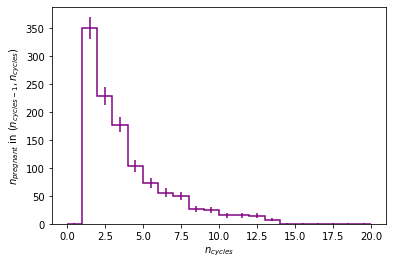

In [230]:
hpreg = hist.Hist(hist.axis.Regular(20, 0, 20, name="n_cycles")).fill(df[df["outcome"] == "pregnant"]["n_cycles_trying"])
hpreg.plot(color='purple')
plt.ylabel("$n_{pregnant}$ in $(n_{cycles-1}, n_{cycles})$")
plt.xlabel("$n_{cycles}$")

The cumulative number of women concieving within $n_{cycles}$ is shown below. A total of 1148 women have concieved by cycle 13.

Text(0.5, 0, '$n_{cycles}$')

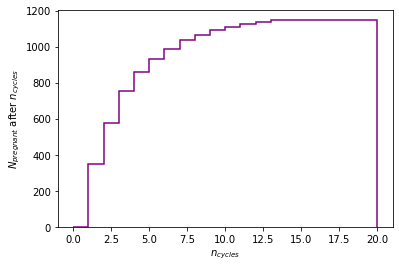

In [231]:
hcumul = hpreg.copy()
hcumul[...] = np.cumsum(hpreg.values(flow=True))
hcumul.plot(yerr=False, color='purple')
plt.ylabel("$N_{pregnant}$ after $n_{cycles}$")
plt.xlabel("$n_{cycles}$")

The histogram below shows the distribution of $n_{cycles}$ for participants who do not achieve conception. When this is is less than the duration of the study, it implies that the particpant has dropped out. This means that the 58% of participants concieving does not give an accurate estimate for the rate of pregnancy within 13 cycles. 

Text(0.5, 0, '$n_{cycles,trying}$')

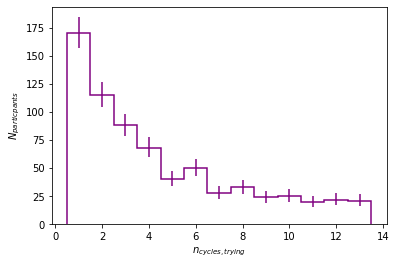

In [233]:
hnon = hist.Hist(hist.axis.Regular(13, 0.5, 13.5, name="n_cycles")).fill(df[df["outcome"] == "not_pregnant"]["n_cycles_trying"])
fig = hnon.plot(color='purple')
plt.ylabel("$N_{particpants}$")
plt.xlabel("$n_{cycles,trying}$")

683 women have $n_{cycles,trying} < 13$. Excluding them from the data set, 87.5% of the women completing the study have achieved conception. However, this clearly overestimates the rate of conception for the general population.

In [241]:
n_exclude = np.count_nonzero((df["outcome"] == "not_pregnant") & (df["n_cycles_trying"] < 13))
print("Number not completing study", n_exclude)
print("Fraction of those completeting the full study achieving pregnancy after 13 weeks", round(n_pregnant/(len(df)-n_exclude), 4))

Number not completing study 683
Fraction of those completeting the full study achieving pregnancy after 13 weeks 0.875


The gradual loss of participants in the study can be acounted for by using the Kaplan-Meier estimator (Kaplan, E. L.; Meier, P. (1958)), as suggpested in the highly relevant study of (Carlotta Favaro et al. 2021). The Kaplan-Meier estimator computes the non-survival (non-pregnancy) rate on a rolling basis, where each time slice (here, each period of 1 cycle) is computed based on the fraction of participants which remain. The total non-pregnancy probability can then be computed as the product of the individual time slice probabilities contributing to the relevant window (here, $\prod_{i=0}^{13}S_{i}$)

First compute the number of participants for each one-cycle period, separating between all participants and those which achieved pregnancy

In [111]:
counts_trying = df["n_cycles_trying"].value_counts()
counts_concieved = df.loc[df["pregnant"], "n_cycles_trying"].value_counts()

In [126]:
# Remaining is the sum of all people with n_cycles_trying < the given period 
remaining = np.full(counts_trying.shape, counts_trying.sum())
remaining[1:] = remaining[1:] - counts_trying.cumsum()[:-1]

Compute the Kaplan-Meier estimator 1-$d_i/n_i$, where $d_i$ is the number of pregnancies 
at time $i$ and $n_i$ is the number of particpants up to $t_i$. This effectively gives the
probability of non-pregnancy in the time slice $(t_{i-1}, t_i)$

In [175]:
kaplan_meier_probs = 1-counts_concieved/remaining[:len(counts_concieved)]
pd.DataFrame(kaplan_meier_probs)

,n_cycles_trying
1,0.824561
2,0.844746
3,0.842617
4,0.879769
5,0.893218
6,0.903282
7,0.894292
8,0.931646
9,0.925373
10,0.944056


The probability to not get pregnant in time slice $(t_i, t_{i+1})$ is the product of the per-slice probabilities.

In [176]:
pd.DataFrame(np.cumprod(kaplan_meier_probs))

,n_cycles_trying
1,0.824561
2,0.696545
3,0.586921
4,0.516354
5,0.461217
6,0.416609
7,0.372570
8,0.347103
9,0.321200
10,0.303231


Of course, it's easier to use a python package directly.
Using here the package lifetimes. Which will compute everything
above, as well as confidence intervals, with only the data needed as input

In [ ]:
kmf_all = KaplanMeierFitter()

In [145]:
kmf_all.fit(df["n_cycles_trying"], event_observed=df["pregnant"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1995 total observations, 847 right-censored observations>

In [146]:
# The result is in agreement with the manual computation
kmf_all.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.824561
2.0,0.696545
3.0,0.586921
4.0,0.516354
5.0,0.461217
6.0,0.416609
7.0,0.372570
8.0,0.347103


Text(0, 0.5, 'Probability of non-conception')

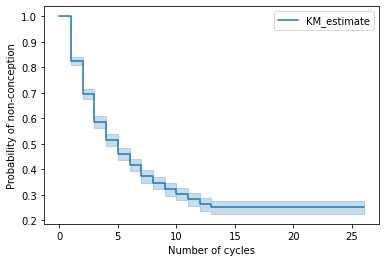

In [149]:
kmf_all.plot_survival_function()
plt.xlabel("Number of cycles")
plt.ylabel("Probability of non-conception")

Text(0, 0.5, 'Probability of conception')

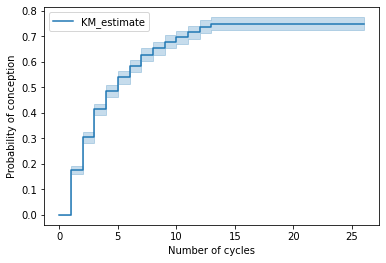

In [150]:
kmf_all.plot_cumulative_density()
plt.xlabel("Number of cycles")
plt.ylabel("Probability of conception")

In [185]:
print("Probability of concieving in <= 13 cycles =", float(1-kmf.survival_function_at_times(13)))

Probability of concieving in <= 13 cycles = 0.749150511801471


In [263]:
print("The 95% confidence level range for concieving within 13 cycles is", 1-kmf.confidence_interval_.iloc[13,:])

The 95% confidence level range for concieving within 13 cycles is KM_estimate_lower_0.95    0.774465
KM_estimate_upper_0.95    0.723107
Name: 13.0, dtype: float64


The best median time to pregnancy is a more reliable estimator of the expected time to pregnancy for this sample than, e.g., the mean, because the mean suffers from long tails that exceed the length of the study. The median value can be evaluated from the Kaplan-Meier curve. It is given by the time period in which the non-survival probability drops below 50%. In this analysis, the median time is 5 cycles. This slightly exceeds the observation of 4 cycles in (Favaro et al. 2021). Differences in the composition of the sample could account for this small difference, as well as the statistical power of the sample.

In [298]:
kmf_all.survival_function_at_times(4), kmf_all.survival_function_at_times(5)

(4    0.516354
 Name: KM_estimate, dtype: float64,
 5    0.461217
 Name: KM_estimate, dtype: float64)

A rough sense of the uncertainty of this can be evaluated from the 95% confidence intervals of the Kaplan-Meier distribution. However, this cannot be directly interpreted as a confidence interval on the median.

In [301]:
kmf_all.confidence_interval_survival_function_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
1.0,0.807151,0.840559
2.0,0.675237,0.716761
3.0,0.563633,0.609426
4.0,0.492255,0.539891
5.0,0.436671,0.485387
6.0,0.391865,0.441146
7.0,0.347689,0.397430
8.0,0.322200,0.372105
9.0,0.296251,0.346384


The mean time to pregnancy within the time period consider in the study is the integral of the Kaplan-Meier function

In [293]:
np.sum(kmf_all.survival_function_)

KM_estimate    9.904717
dtype: float64